In [101]:
import pandas as pd
import os
import random
import gensim.models.doc2vec

from gensim.models.doc2vec import Doc2Vec


df = pd.read_csv('../bostonGlobe/bostonglobe2014.csv')
df.head()

,text
0,['The Boston Police Department has issued a co...
1,"['\n individuals who worked in finance, insura..."
2,"['Dr. Kenneth C. Edelin, whose historic 1975 m..."
3,['The first words in the Bible are “In the beg...
4,"['When they go up, they form the centerpiece o..."


In [102]:
df.iloc[5,0]

"['First Night Boston almost didn’t happen this year. Money ran out, budgets were cut, and then Mayor Thomas M. Menino, in one of his last acts, made sure the show would go on. Here are some of the highlights. For a full listing of events, details on where to buy the $10 First Night buttons, as well as venue information, go to \\n\\n\\n\\n\\n\\nFolk music for all ages is demonstrated by Dan Zanes, former member of  the Del Fuegos band, and Elizabeth Mitchell, a Smithsonian Folkways recording artist. In 2007 Zanes received a Grammy Award and Mitchell was a nominee for the 56th annual Grammy Awards for Best Children’s Album. \\n\\n\\nGroove to the beat of Afro-Brazilian drumming put together by Grooversity and IntAfrika. Created by Brazilian percussionist Marcus Santos, the Grooversity entertainment group not only educates, but also engages others to be a part of social change. \\n\\n\\n\\nAdults and children can learn how to walk the tight wire, use the aerial lyra, and ride the gym whe

In [103]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–", "\xc2", "\xa0",
             "\x80", "\x9c", "\x99", "\x94", "\xad", "\xe2", "\x9d"]

for char in spec_chars:
    df['text'] = df['text'].str.replace(char, ' ')

In [104]:
df.iloc[5,0]

'  First Night Boston almost didn’t happen this year  Money ran out  budgets were cut  and then Mayor Thomas M  Menino  in one of his last acts  made sure the show would go on  Here are some of the highlights  For a full listing of events  details on where to buy the $10 First Night buttons  as well as venue information  go to  n n n n n nFolk music for all ages is demonstrated by Dan Zanes  former member of  the Del Fuegos band  and Elizabeth Mitchell  a Smithsonian Folkways recording artist  In 2007 Zanes received a Grammy Award and Mitchell was a nominee for the 56th annual Grammy Awards for Best Children’s Album   n n nGroove to the beat of Afro Brazilian drumming put together by Grooversity and IntAfrika  Created by Brazilian percussionist Marcus Santos  the Grooversity entertainment group not only educates  but also engages others to be a part of social change   n n n nAdults and children can learn how to walk the tight wire  use the aerial lyra  and ride the gym wheels  If these

In [105]:
def tokenize(text, stopwords, max_len = 20):
    return [token for token in gensim.utils.simple_preprocess(text, max_len=max_len) if token not in stopwords]

In [106]:
articles = df.values.tolist()
articles_flat = [item for sublist in articles for item in sublist]
tagged_docs = [gensim.models.doc2vec.TaggedDocument(tokenize(text, [], max_len=200), [i]) for i, text in enumerate(articles_flat)]

In [107]:
tagged_docs[5]

TaggedDocument(words=['first', 'night', 'boston', 'almost', 'didn', 'happen', 'this', 'year', 'money', 'ran', 'out', 'budgets', 'were', 'cut', 'and', 'then', 'mayor', 'thomas', 'menino', 'in', 'one', 'of', 'his', 'last', 'acts', 'made', 'sure', 'the', 'show', 'would', 'go', 'on', 'here', 'are', 'some', 'of', 'the', 'highlights', 'for', 'full', 'listing', 'of', 'events', 'details', 'on', 'where', 'to', 'buy', 'the', 'first', 'night', 'buttons', 'as', 'well', 'as', 'venue', 'information', 'go', 'to', 'nfolk', 'music', 'for', 'all', 'ages', 'is', 'demonstrated', 'by', 'dan', 'zanes', 'former', 'member', 'of', 'the', 'del', 'fuegos', 'band', 'and', 'elizabeth', 'mitchell', 'smithsonian', 'folkways', 'recording', 'artist', 'in', 'zanes', 'received', 'grammy', 'award', 'and', 'mitchell', 'was', 'nominee', 'for', 'the', 'th', 'annual', 'grammy', 'awards', 'for', 'best', 'children', 'album', 'ngroove', 'to', 'the', 'beat', 'of', 'afro', 'brazilian', 'drumming', 'put', 'together', 'by', 'groove

In [108]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, epochs=40, window=2, dm=1)
model.build_vocab(tagged_docs)
model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [109]:
vector = model.infer_vector(['black', 'african american', 'african-american', 'haitian', 'jamaican', 'west indian', 'dominican'])

print(vector)

[ 0.0428128  -0.18126217  0.17942856  0.00885469 -0.24291092  0.3307422
 -0.33543777 -0.23396267 -0.02229096 -0.17077258 -0.12581725 -0.10657031
 -0.10971361  0.4776044  -0.66968644  0.60414946 -0.20317252  0.61836094
 -0.18801548  0.33015284  0.27473482 -0.7181789   0.6494267   0.5245655
  0.18551011  0.27751303  0.00867458  0.09935061 -0.11014274 -0.09480754]


In [110]:
def pick_random_word(model, threshold=10):
    # pick a random word with a suitable number of occurences
    while True:
        word = random.choice(model.wv.index_to_key)
        if model.wv.get_vecattr(word, "count") > threshold:
            return word

#target_word = pick_random_word(model)
# or uncomment below line, to just pick a word from the relevant domain:
target_word = ['black', 'haitian', 'jamaican', 'dominican']

diction = {}

for w in target_word:
    print(f'target_word: {repr(w)} model: {model} similar words:')
    for i, (word, sim) in enumerate(model.wv.most_similar(w, topn=15), 1):
        diction[sim] = word
        print(f'    {i}. {sim:.2f} {repr(word)}')
    print()

target_word: 'black' model: Doc2Vec(dm/m,d30,n5,w2,mc5,s0.001,t3) similar words:
    1. 0.83 'latino'
    2. 0.78 'grieving'
    3. 0.78 'masked'
    4. 0.77 'white'
    5. 0.76 'vietnamese'
    6. 0.72 'young'
    7. 0.70 'asian'
    8. 0.68 'hispanic'
    9. 0.67 'kidnaps'
    10. 0.67 'pakistani'
    11. 0.66 'muslim'
    12. 0.66 'smart'
    13. 0.66 'liberian'
    14. 0.65 'glamorous'
    15. 0.65 'slain'

target_word: 'haitian' model: Doc2Vec(dm/m,d30,n5,w2,mc5,s0.001,t3) similar words:
    1. 0.77 'american'
    2. 0.73 'asian'
    3. 0.72 'pygmy'
    4. 0.71 'japanese'
    5. 0.70 'irish'
    6. 0.70 'captive'
    7. 0.68 'vietnamese'
    8. 0.67 'young'
    9. 0.67 'derived'
    10. 0.67 'muslim'
    11. 0.67 'french'
    12. 0.67 'lebanese'
    13. 0.67 'female'
    14. 0.66 'verdean'
    15. 0.65 'émigré'

target_word: 'jamaican' model: Doc2Vec(dm/m,d30,n5,w2,mc5,s0.001,t3) similar words:
    1. 0.68 'marble'
    2. 0.67 'roundtable'
    3. 0.66 'pygmy'
    4. 0.65 'boxy'
  

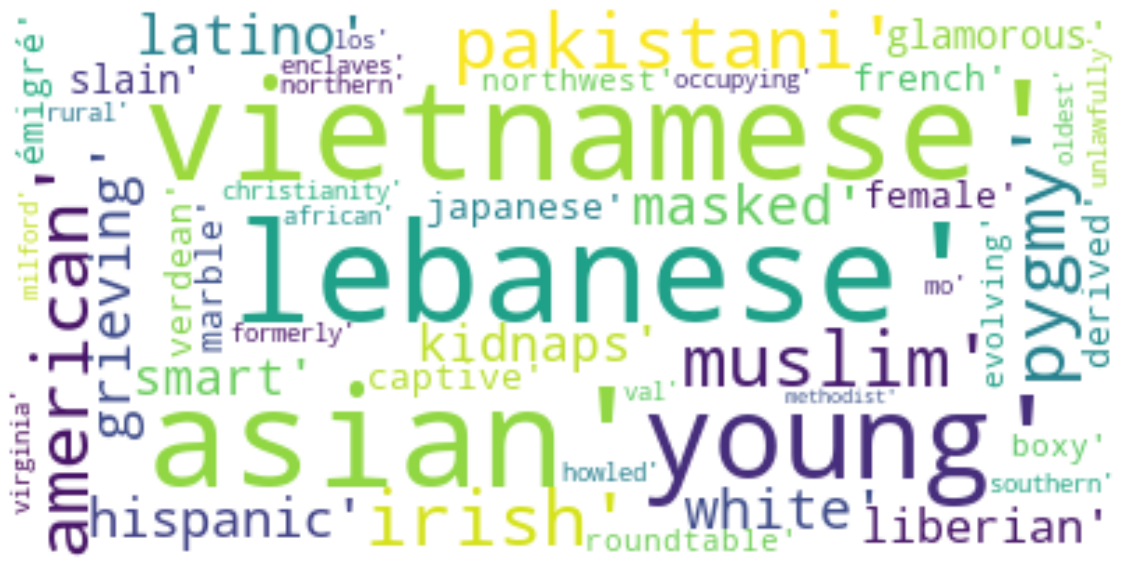

In [111]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
'''from pandas import DataFrame
df = DataFrame (words,columns=['keywords'])'''
diction = str(diction)
text = diction
#print(words)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("../img/word_cloud.png")

In [112]:
def compute_similar_words(model,source_word, topn=5):
    ''' For the given the source word, capture all the topn words'''
    print('\r Computing similar words for the source word - {0:35s}'.format(source_word),end='')

    similar_words = [source_word]
    
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)

    return similar_words    

In [113]:

keywords = ['black', 'haitian', 'jamaican', 'dominican']
def compute_similar_words_for_all_tasks(model,topn=5):
    '''For all the words provided in the keyword list, capture the topn similar words'''
    
    columns = ['word'+str(i-1) for i in range(1,topn+2)]

    df = pd.DataFrame(data=None,columns=columns)
    
    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word,topn)
        df.loc[len(df)] = similar_words
        
        for i in range(1,len(similar_words)):
            sec_similar_words = compute_similar_words(model,similar_words[i],topn)
            df.loc[len(df)] = sec_similar_words

    df.to_csv('similar_words_task1.csv')

In [114]:
compute_similar_words_for_all_tasks(model)

 Computing similar words for the source word - irish                              

In [117]:
import networkx as nx

def display_graph():

    words = pd.read_csv('similar_words_task1.csv')
    g = nx.Graph()

    j = 1
    for i, row in words.iterrows():
        for j in range(1,len(row)):
            g.add_node(i,label=row[j])
        for j in range(1,len(row)):
            g.add_edge(row[1], row[j])    


    plt.rcParams["figure.figsize"] = 20,19

    options = {
        'node_color': 'blue',
        'node_size': 4,
        'linewidths': 0,
        'width': 0.5,
        'font_size':11,
    }

    subgraph = nx.node_connected_component(g,'black')
    nx.draw(g.subgraph(subgraph), with_labels=True, **options)

    #nx.write_graphml(g.subgraph(subgraph), "results.graphml")
    plt.show()

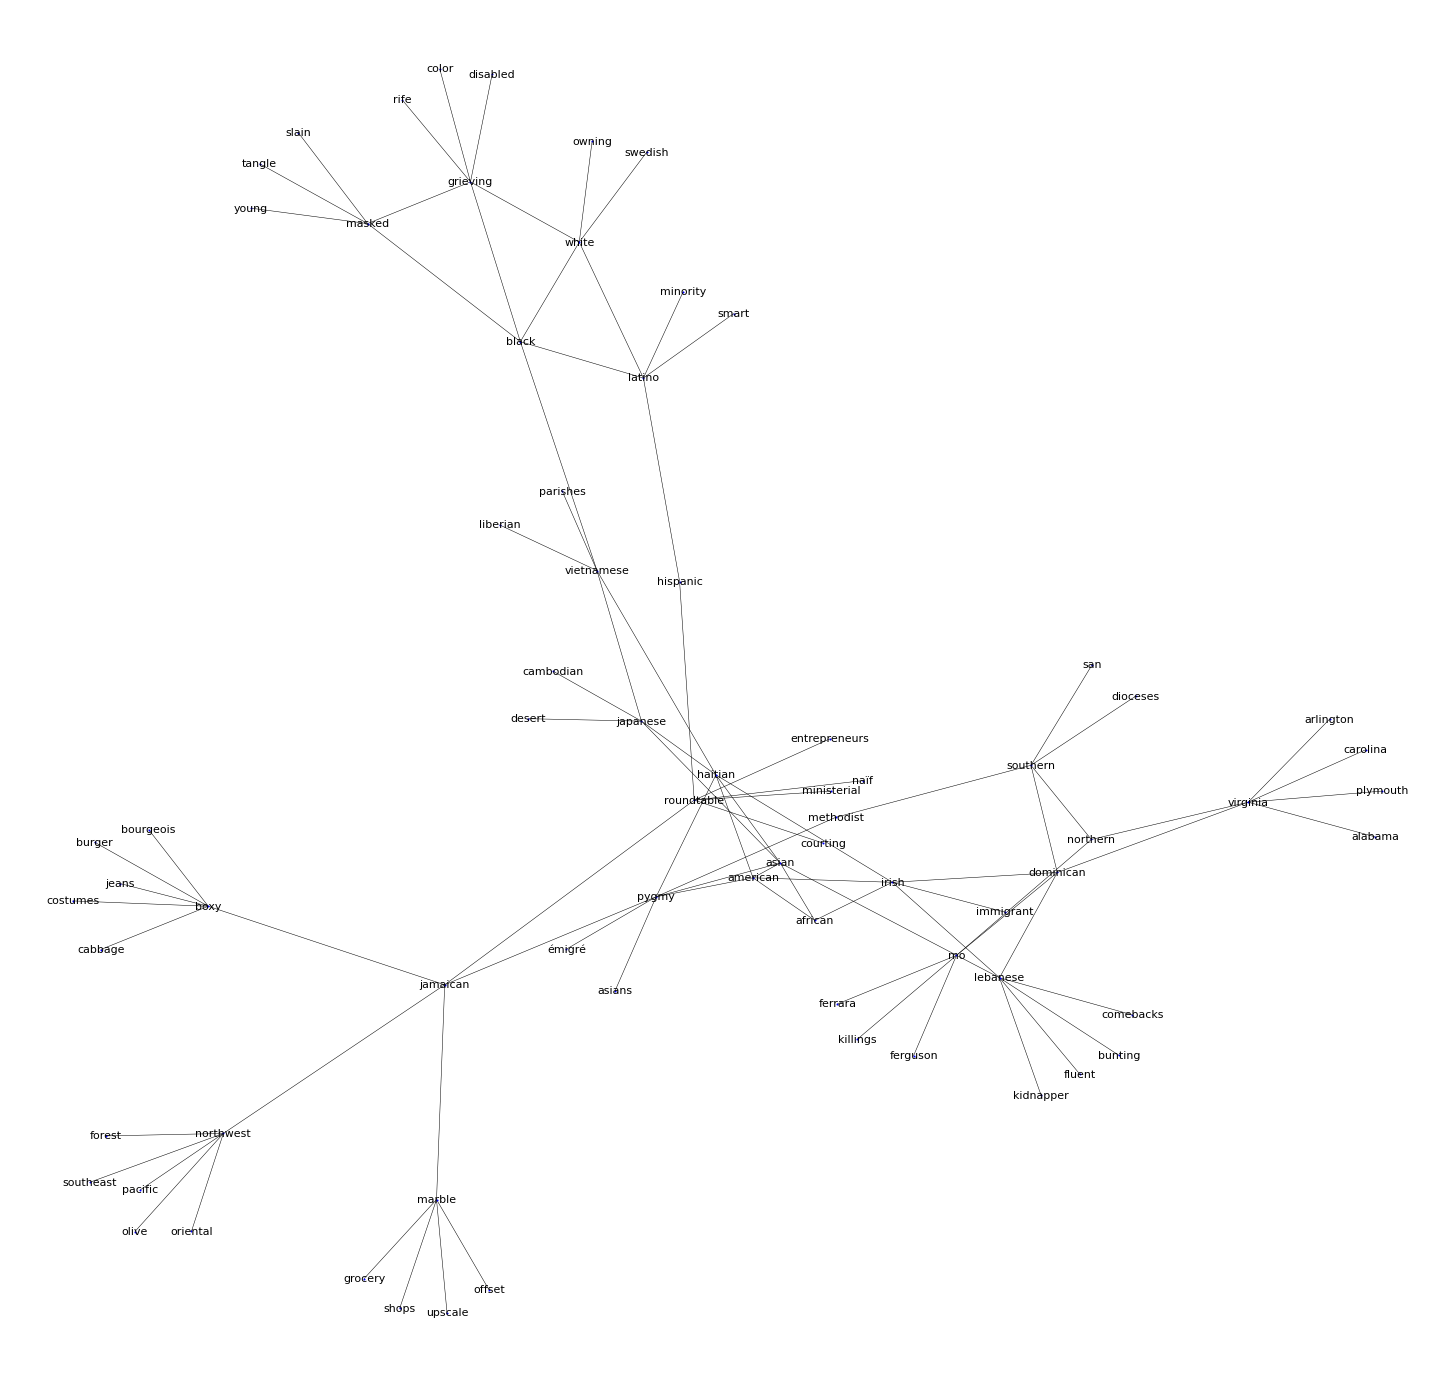

In [118]:
display_graph()